# **3.2 ED :: Operators based on the second derivative**

In the same way as we can detect edges by looking at the gradient (first-derivative) image, it is also possible to do that by analyzing the output of operators based on the second-derivative. Concretely, the **zero crosses** of the output correspond to edges, as the second derivative is zero when the first derivative is maximum (or minimum).

Unfortunately, depending on the edge orientation, this zero-crossing may go almost unnoticed. The solution is combining second derivatives in perpendicular directions.

In this notebook we are going two explore two methods that face such issue and detect edges using the second derivative. These are:

- **Laplacian operator** (Section 3.2.1)
- **LoG operator** (Section 3.2.2)

Additionally, we will address a widely used algorithm that is a combination of different techniques: the **Canny algorithm** (Section 3.2.3).

**This notebook contains <font color=green>2 assignments</font> and <font color=blue>2 discussions</font>**

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, fixed, widgets
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
images_path = '/gdrive/My Drive/Colab Notebooks/Chapter 3. Edge detection/images/'

## **3.2.1 The Laplace operator**

Compared with the first derivative-based edge detectors such as the Sobel operator, the Laplace operator may yield better results in edge localization, since it is:
- a linear operator,
- robust against noise,
- precise when localizing objects.

The idea behind it is to combine second derivatives in perpendicular directions. Thus, it is defined as:

$$
\nabla^2 f(x,y) =
\frac{\partial^2}{\partial x^2}f(x,y) +
\frac{\partial^2}{\partial y^2}f(x,y)
$$

Note that, by definition, **it returns a scalar**, not a vector as in the gradient case.

This operator is implemented as a kernel `g+h` that performs the second derivative in perpendicular directions (refer to the course slides for a complete derivation):

<table>
	<tr>
		<td align=center><b>g</b></td>
		<td></td>
		<td align=center><b>h</b></td>
		<td></td>
		<td align=center><b>g+h=L</b></td>
	</tr>
	<tr>
		<td align=center>
			$$\begin{bmatrix}
				0 & 0 & 0 \\
				1 & \color{blue}{-2} & 1 \\
				0 & 0 & 0
			\end{bmatrix}
			$$    
		</td>
		<td>+</td>
		<td align=center>
			$$\begin{bmatrix}
				0 & 1 & 0 \\
				0 & \color{blue}{-2} & 0 \\
				0 & 1 & 0
			\end{bmatrix}
			$$    
		</td>
		<td>=</td>
		<td align=center>
			$$\begin{bmatrix}
				0 & 1 & 0 \\
				1 & \color{blue}{-4} & 1 \\
				0 & 1 & 0
			\end{bmatrix}
			$$    
		</td>
	</tr>
</table>


### **Zero-crossing**

After applying this kernel, **it is needed an algorithm to detect zero-crossings** in order to return a binary image of edges. An example of a simple zero-crossing algorithm:

1. Select a small positive number (threshold) $th$.
2. A pixel is labelled as an edge if in the Laplacian image:
   - its value is smaller than $-th$ and at least one of its neighbours is bigger that $th$, or
   - its value is bigger than $th$ and at least one of its neighbours is smaller than $-th$.

### **Limitations**

Unfortunately, the Laplacian operator is very sensitive to noise, resulting in poor edge detection. Solution: If the image is blurred using a Gaussian filter before applying the Laplace operator, we can partially solve the noise problem. In this case, it is called **LoG (Laplace of Gaussian)**.

## **3.2.2 LoG operator**

So, the LoG operator first smoothes the image, and then applies the Laplacian operator, which applying the convolution properties gets to:

$$
\nabla^2[f(x,y)\otimes g_\sigma(x,y)]
=
f(x,y) \otimes \nabla^2[g_\sigma(x,y)]
= f(x,y) \otimes LoG_\sigma(x,y)
$$

LoG is an isotropic operator, that is, it keeps radial symmetry. In this way, it is assumed that the covariance in both image dimensions is the same!

$$LoG_\sigma (x,y) = \frac{1}{\pi \sigma^4}
\left[ \frac{x^2+y^2}{2 \sigma^2} -1 \right] \exp^{-\frac{x^2+y^2}{2 \sigma^2}}
=
\left[ \frac{r^2}{2 \sigma^2} -1 \right] \exp^{-\frac{r^2}{2 \sigma^2}}
= LoG_\sigma(r^2)
$$

**Let's print the LoG operator!**

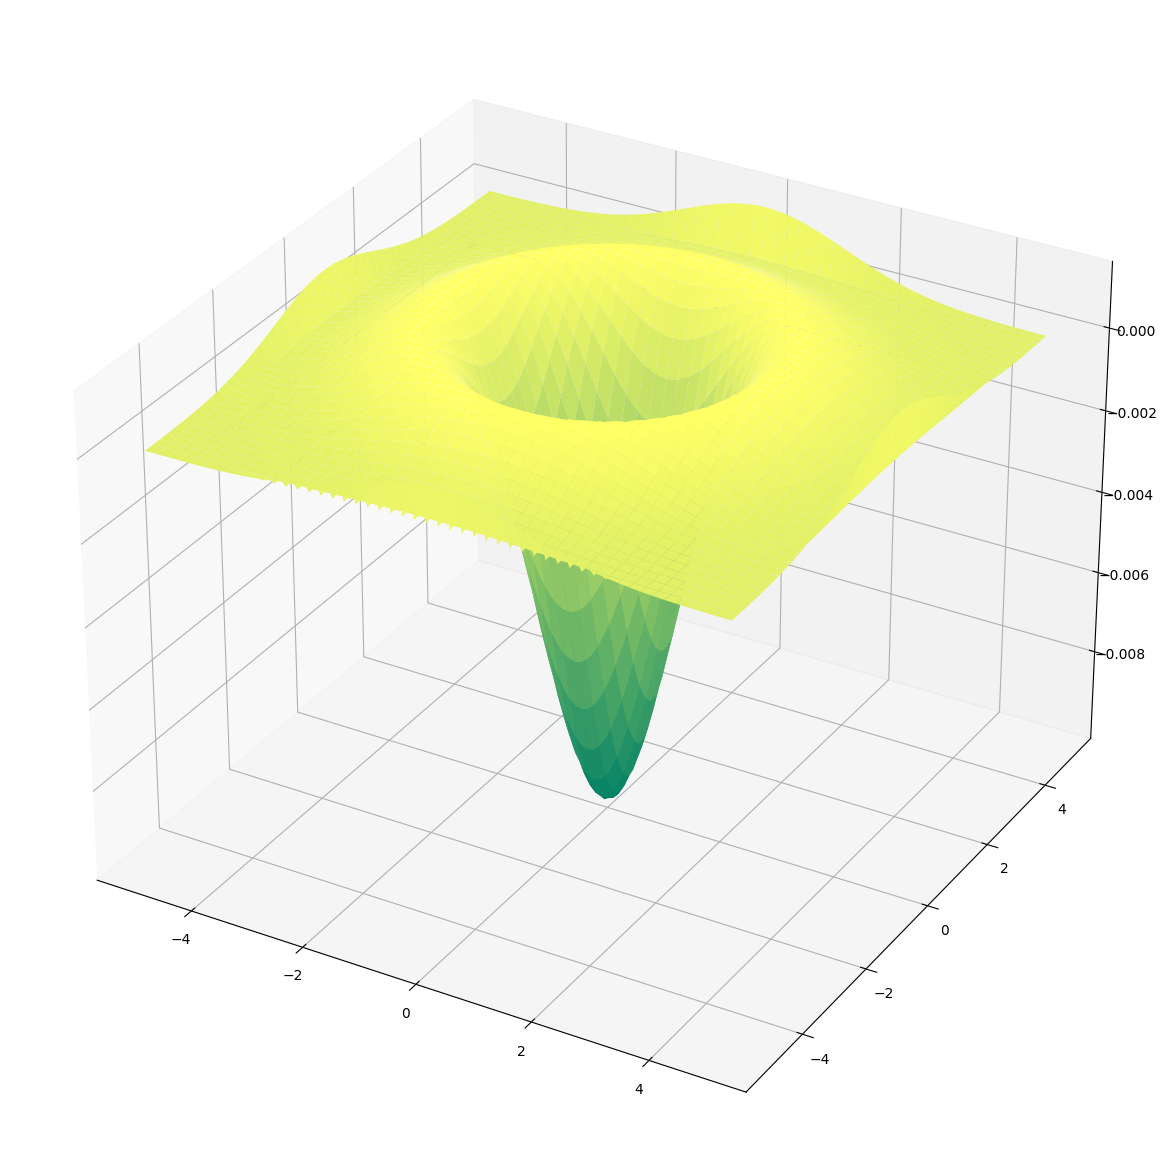

In [3]:
# Gauss filter
v = np.arange(-5,5,0.1)
X, Y = np.meshgrid(v,v)
covar = np.array([[2, 0],[0, 2]]) ## Assuming no correlation between X and Y
gauss_filter = np.exp(-0.5*(X**2/covar[0][0]+Y**2/covar[1][1]))

# Laplace filter
laplace_filter = np.array(([[0,1,0],[1,-4,1],[0,1,0]]), dtype="float")

# LoG operator
LoG = cv2.filter2D(gauss_filter, -1, laplace_filter)

# Plot it!
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X,Y,LoG,cmap='summer', edgecolor='none')

As a side note, the LoG is not separable, but it can be implemented as **DoG (Difference of Gaussians)**, a sum of separable operators, reducing its complexity from $O(N^2)$ to $O(4N)$:

$$
DoG_{\sigma_1\sigma_2}(x,y) =
g_{\sigma_1}(x,y) - g_{\sigma_2}(x,y) =
g_{\sigma_1}(x)g_{\sigma_1}(y) - g_{\sigma_2}(x) g_{\sigma_2}(y)
$$

Giving the ration $\sigma_1 / \sigma_2 = 1.6$ the best approximation of LoG. This complexity reduction approach is employed in the SIFT keypoint detector, as we will see in following notebooks.

### **Limitations of the LoG operator**

- It is computationally costly.
- It doesn't provide any information about edge orientations.
- The output contains negative and non-integer values, so for display purposes the image should be normalized to the range $[0,255]$.
- It is needed a zero-crossing method.
- It tends to round object corners (more heavily as $\sigma$ grows).

### **<font color=green>ASSIGNMENT #1a: Applying Gaussian smoothing</font>**

Now that we are almost experts in the Laplacian and LoG operators, let's play a bit with them!

First, complete the function `gaussian_smoothing()` that blurs an image using a Gaussian filter. Then, normalizes it and returns the resulting image.

> <font color=orange> Note that this is just the same that you did in Chapter 2 but adding the normalization step. Feel free to take the code from there. </font>

In [4]:
# ASSIGNMENT  #1a
# Implement a function that blurres an input image using a Gaussian filter and then normalizes it.
def gaussian_smoothing(image, sigma, w_kernel):
    """ Blur and normalize input image.

        Args:
            image       : [numpy array] grayscale image to be smoothed
            sigma       : [num] standard deviation of Gaussian distribution
            w_kernel    : [integer] kernel aperture size (width = 2*w_kernel+1)

        Returns:
            smoothed_img: [numpy array] smoothed image

    """
    # Write your code here!
    kernel_1d = [np.exp(-z*z/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma) for z in range (-w_kernel, w_kernel+1)]
    kernel_2d = np.outer(kernel_1d,kernel_1d)
    image_filter = cv2.filter2D(image,cv2.CV_16S,kernel_2d)
    smoothed_norm=cv2.normalize(image_filter,None, 0, 255, cv2.NORM_MINMAX)
    return smoothed_norm

### **<font color=green>ASSIGNMENT #1b: Detecting edges with Laplace and LoG</font>**

Now, we are going to see the differences between the Laplace and LoG operators.

Complete `laplace_testing()` that applies the Laplacian operator to
- the input image
- a smoothed version of the input image (use the previously implemented function to smooth it).

Then, display both images along with the original one in a $1\times3$ plot. Use as inputs: an image, the size of the Laplacian filter (**this should be odd**), and the parameters of the Gaussian filter.

Note that it would possible to reduce the computation time if LoG would be precomputed. This is convolving Laplace and Gaussian filters instead of applying them separatelly.

> <font color=orange> Tip: OpenCV defines Laplace operator as [cv2.Laplacian()](https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html). Check its documentation!

In [5]:
# ASSIGNMENT #1b
# Implement a function that applies the Laplacian operator to the input image and to a blurred version of it.
# Display a 1x3 plot with the original image and the two resulting edge images.
# Inputs: image, size of the Laplacian kernel, sigma and size of the Gaussian kernel
def laplace_testing(image, w_lap_kernel, sigma, w_gaussian):
    """ Apply Laplacian and Log operators to an image.

        Args:
            image       : [numpy array] grayscale image
            w_lap_kernel: [integer] size of the Laplacian kernel (odd)
            sigma       : [num] standard deviation of Gaussian distribution
            w_gaussian  : [integer] Gaussian kernel aperture size (width = 2*w_kernel+1)

        Returns:
            None
    """
    # Write your code here!
    smoothed_norm = gaussian_smoothing(image,sigma,w_gaussian)
    laplacian_image = cv2.Laplacian(image,cv2.CV_16S,w_lap_kernel)
    log_image = cv2.Laplacian(smoothed_norm,cv2.CV_16S,w_lap_kernel)

    plt.figure(1)
    plt.subplot(1,3,1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(laplacian_image, cmap='gray')
    plt.title('Laplacian image')
    plt.subplot(1,3,3)
    plt.imshow(log_image, cmap='gray')
    plt.title('Log image')

It is time to try this method to our medical images and play with interactive parameters.$\\[5pt]$      

In [6]:
# Read an image
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Interact with the parameters!
interact(laplace_testing, image=fixed(image), w_lap_kernel=(1,7,2), sigma=(1,3,0.1), w_gaussian=(1,3,1))

interactive(children=(IntSlider(value=3, description='w_lap_kernel', max=7, min=1, step=2), FloatSlider(value=…

<function __main__.laplace_testing(image, w_lap_kernel, sigma, w_gaussian)>

#### **<font color=red><b>Expected output</b></font>**

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch3/insert/ch32_a1b_result.png" width="900">
</center>

#### **<font color=blue>Discussion #1</font>**

Now, **answer the following questions**:

- Can be the Laplacian applied without a previous blurring?
  
    <font color=blue><b>yes it could be</b></font>

- Find the set of parameters to get the best results, in your opinion
  
    <font color=blue><b>w_lap_kernel = 3, sigma = 1.2, w_gaussian = 2</b></font>

## **3.2.3 The Canny algorithm**

The Canny edge detector is an algorithm designed to be a good detector, yield a good localization, and to provide  single response!

This algorithm consists of the following steps:

1. *Noise filtering*. Filter out any noise using a Gaussian filter.$\\[5pt]$

2. *Obtain the gradient image*. Apply the DroG operator.$\\[5pt]$

3. *Non-maximum suppression* is applied.

4. *Hysteresis*: The final step. Canny uses two thresholds (upper and lower) to determine edge pixels.

Let's try it!

### **<font color=green>ASSIGNMENT #2: Detecting edges with the Canny algorithm</font>**

Complete `canny_testing()`, which applies the Canny algorithm to an image and to a blurred version of it *(note that OpenCV Canny's implementation does not apply Gaussian blurring)*. Then both are displayed along the original image. This function should take as input an image, both lower and upper Canny thresholds, and the parameters of the Gaussian filter as input.

> <font color=orange>Note: use `gaussian_smoothing` to blur the image.

> Tip: OpenCV implements the Canny algorithm as [cv2.Canny()](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny). Check its documentation.</font>

In [7]:
# ASSIGNMENT #2
# Implement a function that applies the Canny operator to an input image and to a blurred version of it.
# Display a 1x3 plot with the original image and the two resulting edge images.
# Inputs: image, size of the Laplacian kernel, sigma and size of the Gaussian kernel
def canny_testing(image, lower_th, upper_th, sigma, w_gaussian):
    """ Apply Canny algorithm to an image.

        Args:
            image       : [numpy array] grayscale image
            lower_th    : [integer] lower value for hysteresis
            upper_th    : [integer] upper value for hysteresis
            sigma       : [num] standard deviation of Gaussian distribution
            w_gaussian  : [integer] Gaussian kernel aperture size (width = 2*w_kernel+1)

        Returns:
            None

    """
    # Write your code here!
    smoothed_norm = gaussian_smoothing(image,sigma,w_gaussian)
    canny1=cv2.Canny(image,lower_th,upper_th)
    smoothed_norm = np.uint8(smoothed_norm) #Función CANNY solicita formato UINT8.
    canny2=cv2.Canny(smoothed_norm,lower_th,upper_th)

    plt.figure(1)
    plt.subplot(1,3,1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(canny1, cmap='gray')
    plt.title('Canny image')
    plt.subplot(1,3,3)
    plt.imshow(canny2, cmap='gray')
    plt.title('Canny image after smoothing')

Among the multiple parameters of this algorithm, it is interesting to check its performance with different levels of smoothing (changing the sigma of the DroG operator). Different sigma produces edges at different spatial features. **Try the effect of this and other parameters** playing with them.$\\[5pt]$      

In [8]:
# Read an image
image = cv2.imread(images_path + 'medical_2.jpg', 0)

# Interact with the parameters
interact(canny_testing, image=fixed(image), lower_th=(0,260,20), upper_th=(0,260,20), sigma=(1,3,0.1), w_gaussian=(1,3,1))

interactive(children=(IntSlider(value=120, description='lower_th', max=260, step=20), IntSlider(value=120, des…

<function __main__.canny_testing(image, lower_th, upper_th, sigma, w_gaussian)>

#### **<font color=red><b>Expected output</b></font>**
<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch3/insert/ch32_a2_result.png" width="900">
</center>

#### **<font color=blue>Discussion #2</font>**

Now, **answer following questions**:

- Can be Canny applied without a previous blurring?
  
    <font color=blue><b></b></font>
   
- What is a *good* value for both thresholds?
  
    <font color=blue><b>lower_th = 60, upper_th = 120</b></font>
    
- Now that you have tried a good number of edge detection methods, **which one is your favorite, and why?**

  <font color=blue><b>Your answer here!</b></font>

## **Conclusion**

Terrific! You finished this notebook, that includes information about:

- Laplace and LoG operators and the importance of smoothing.
- how to use the Canny algorithm, and how it is implemented.

## **Extra**

The Canny algorithm is a very known algorithm in the field, it is used in a lot of current technologies. Although it still gets very good results, the original paper was published by John Canny in 1986!:

> <font color=orange>CANNY, John. [A computational approach to edge detection.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwiU9uyiganoAhWNDWMBHducCvsQFjAJegQIBhAB&url=http%3A%2F%2Fciteseerx.ist.psu.edu%2Fviewdoc%2Fdownload%3Fdoi%3D10.1.1.420.3300%26rep%3Drep1%26type%3Dpdf&usg=AOvVaw3tsKoxnc3qnS7bji3HmvQc). IEEE Transactions on Pattern Analysis and Machine Intelligence, 1986, no 6, p. 679-698.</font>